# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

3 PROBLEMES
* ESS toujours au max à chaque itération --> sigma2 = 10e141 écrase (consumption - x_pred)
* valeurs négatives de x
* x_season est négligeable devant x_heat


In [205]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage

### Parameters

In [206]:
M=10**5 #number of particles
n_pred=48  #number of predictions
N_daytype=8  #number of day types

In [228]:
#Define functions for filtering and regularization of weigths for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5 - Residual Multinomial Sampling
    #R=sum(np.floor(M*w_h))  #number of (normalized) weights over 1/M
    R=len(w_h[w_h>1/M])
    print("R=",R)
    z=np.zeros(M)
    #z[:R-1]=x_h[:R-1]
    z[:R]=x_h[w_h>1/M]  #Copy the R particles having weight >1/M
    w_=np.ones(M)
    for j in range(M):
        w_[j]=(M*w_h[j]-np.floor(M*w_h[j]))/(M-R)
    print("w_:",w_)
    z[R:]=np.random.multinomial(1,w_[R:],1)*w_[R:]
    w=np.ones(M)*(1/M)
    return z, w

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

In [5]:
#test the functions on random sample
M=10
x_temp=abs(npr.normal(size=10))
w_temp=np.repeat(0.1,10)*npr.uniform(0.1,1.5,size=10)
#print(w_temp)
xtest,wtest=resid_resample(x_temp,w_temp)
print(xtest)
print(wtest)
M=10**5

R= 7.0
w_: [ 0.0159879   0.06046857  0.21358683  0.06269248  0.06383073  0.14574677
  0.27535135  0.13235386  0.01118209  0.00861518]
[ 2.25074427  1.61645655  1.15057606  1.27556356  1.93147651  1.70185933
  0.30205804  0.13235386  0.          0.        ]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
regul(npr.normal(size=10),np.repeat(0.1,10))

array([ 1.67835952, -0.49256673,  0.18780915, -1.67773688, -0.1797055 ,
        1.42578154, -0.28216233,  0.36459449, -1.99712357,  1.00452261])

### Load temperatures data

In [208]:
df_temp=pd.read_csv('data/temp_2016.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,t,hour
1707,2016-01-01,9.044444,09:00
1710,2016-01-01,11.005556,18:00
1709,2016-01-01,11.437736,15:00
1708,2016-01-01,11.196296,12:00
1711,2016-01-01,10.683333,21:00


In [209]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [210]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df.index=range(0,len(df))
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
0,2008-01-01T13:00:00+01:00,2008-01-01,13:00,62844,DÃ©finitive,6
1,2008-01-01T11:30:00+01:00,2008-01-01,11:30,59636,DÃ©finitive,6
2,2008-01-01T09:00:00+01:00,2008-01-01,09:00,55268,DÃ©finitive,6
3,2008-01-01T04:30:00+01:00,2008-01-01,04:30,57917,DÃ©finitive,6
4,2008-01-01T03:30:00+01:00,2008-01-01,03:30,60586,DÃ©finitive,6


In [211]:
#On se concentre d'abord sur une année afin d'initialiser le filtre
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]
df.index=range(0,len(df))

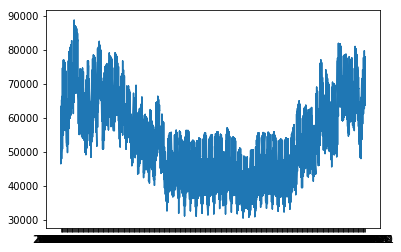

In [18]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

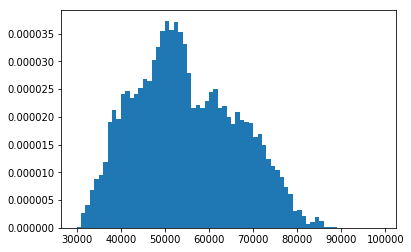

In [11]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

### Set variables of electricity demand for partile 

In [236]:
df['Consommation']=df['Consommation (MW)']   #leave it in MW
df.head()
#df[df['Heure']=='14:00'][['Date', 'Consommation (MW)', 'daytype']][:30]
#prediction 48h ahead
consumption_day_ahead = list(df[df['Date']>'2016-01-30']['Consommation'][:48])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])
temperature_ts = T_h[:30] #france mean temp in jan 2016
daytype_ts = list(df[df['Heure']=='15:00']['daytype'][:30])

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

In [220]:
#Add a bit of noise with uniform random
#s=8000*np.ones(M)*npr.uniform(0.5,1.5,size=M)
#sigma2_g_star=(10**5)*npr.uniform(0.5,1.5,size=M)
#sigma2_s_star=(10**5)*npr.uniform(0.5,1.5,size=M)
sigma_g_init=1.27*10**(8/2)
sigma_s_init=(2*7.9)*10**3
u_h=14 #mean of N(14,1)
kappa=np.array([1/9]*9)
sigma2=2.7*10**7
g_heat_init = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s_init = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)
sigma_s_star_2_evol=7.9*10**7
sigma_g_star_2_evol=1.27*10**8

x_init=x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0]+x_heat(g_heat_init,15,sigma_g_init)[0]
w_init= np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4838: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


In [221]:
x_init[:10]

array([ 11207.26366299, -12211.21377574,  41578.28481568,  21288.25209163,
        17534.93102177,  18438.30767951,   -255.3084417 ,  16757.83731906,
         2232.63649792,   -585.02155657])

In [222]:
print(x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0][:10])

[ 1843.41800756   786.89542877  2274.19344192  1688.18031182  1343.96757308
  2189.02820228  1764.32360492  1236.34429908  1779.03294738  1651.16947868]


In [223]:
print(x_heat(g_heat_init,15,sigma_g_init)[0][:10])

[  92127.66621109   69765.71135115  122067.91192941  102363.89233547
   98954.78400435   99013.10003289   80744.18850903   98285.31357563
   83217.4241062    80527.62952041]


In [224]:
#Compute w_init
w_init = np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))
#print(w_init[:100])
sum(w_init)/M
sum(np.floor(w_init*M))
w_norm=w_init/np.sum(w_init)
print(sum(np.floor(M*w_norm)))
print(len(w_norm[w_norm>1/M]))

95753.0
6844


In [225]:
np.mean(w_init)

0.032082923777483889

In [226]:
M*w_norm[:100]

array([  1.52552272e-22,   3.11302950e-47,   1.16201261e-03,
         1.24695734e-14,   2.19243835e-17,   1.05854323e-16,
         1.58689986e-33,   5.52369073e-18,   5.80698854e-31,
         7.13452331e-34,   9.27122476e-22,   2.27721400e-19,
         2.38308323e-49,   1.50119488e-37,   3.40189102e-23,
         9.01061677e-22,   1.76084160e+00,   6.10382893e-51,
         3.64980911e-63,   3.88502441e-21,   2.15502111e-62,
         1.72578457e-06,   2.89343761e+01,   3.56221365e-69,
         5.47743855e-03,   4.94628913e-61,   1.20054452e-20,
         1.69905702e+00,   1.63732242e-32,   4.40127160e-72,
         1.61238049e-47,   7.19830368e-48,   1.00672345e-05,
         4.12948250e-18,   3.08818887e-19,   2.05399393e-64,
         7.38463785e-56,   5.34740482e-32,   3.83103647e-15,
         1.42696576e-55,   2.65233930e-17,   8.71408852e-64,
         9.88550413e-62,   2.64554394e-34,   2.11877342e-27,
         4.41729559e-52,   2.17271985e-50,   3.74762243e-69,
         5.60958100e-07,

In [156]:
consumption[15]

65044

### Option B: generate initial parameters based on prior distribution

In [ ]:
sigma2=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
g_h = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)


u_h=npr.normal(14,1)  #fixed parameter, invariant to time
k_day=npr.dirichlet(np.ones(N_daytype),1)[0]

C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: overflow encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)


#### 1.B. Calculate x and w at initial state based on initial parameters

In [ ]:
#initialize matrix of x, x_heat, x_season
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])

daytype_init=1
day_init=1

#Calculate x0 and w0 before filtering
x_season[0,:]=k_day[daytype_init]*s
if T_h[day_init]-u_h >0:
    x_heat[0,:]=g_h*(T_h[day_init]-u_h)*1
else:
    x_heat[0,:]=np.zeros(M)

x_0=x_season[0,:]+x_heat[0,:]   #ignore x_cool for now
w0_=x_0+npr.normal(0,sigma2,size=M)  #compute w_wave = g(y_0 l X_0)

#### 2.B.Compute the weights and re-assess the values of X_0 and w_0 based on ESS value


In [186]:
import math
w =np.zeros([n_pred+1,M])  #initalize matrix of weights w
w0_h=w0_/sum(w0_)   #set w_hat
ESS_0=1/(sum(w0_h)**2)  #calculate ESS
if math.isnan(ESS_0):
    ESS_0=1
print(ESS_0)
if ESS_0 <0.001*M:
    x[0,:]=x_0
    w[0,:]=np.ones(M)*(1/M)  #reset the weights
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_0,w0_h)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_0
    w[0,:]=w0_

### Option C: MCMC using MHA or Gibbs (TBA)

In [212]:
import numpy as np
from scipy.stats import truncnorm, invgamma
import math

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [12]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
#kappa = k_day[0].tolist()

In [201]:
#Load pickle file
import pickle
output_file ='data/parameters_init.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init["x_init"][:20]

array([  1.16093549e+11,   6.10701946e+10,   5.74572969e+09,
         4.75739198e+09,   4.11648732e+09,   3.72364616e+09,
         3.47391174e+09,   3.30766255e+09,   3.19165005e+09,
         3.10675781e+09,   3.04159846e+09,   2.98916605e+09,
         2.94503083e+09,   2.90633069e+09,   2.87118720e+09,
         2.83835551e+09,   2.80700763e+09,   2.77659420e+09,
         2.74675410e+09,   2.71725420e+09])

In [56]:
parameters_init["s_init"][:20]

array([ 37086.80181732,  16394.97257234,   4622.74073324,   4031.99239891,
         3653.90126172,   3366.43559475,   3130.50452295,   2928.16815611,
         2749.656668  ,   2589.10279558,   2442.74098667,   2308.02707465,
         2183.16430665,   2066.83297664,   1958.02820575,   1855.95994147,
         1759.98926479,   1669.58633244,   1584.3029652 ,   1503.75262386])

In [54]:
parameters_init["g_heat_init"][:20]

array([ -2.45189115e+10,  -1.28980009e+10,  -1.21349578e+09,
        -1.00475925e+09,  -8.69400444e+08,  -7.86432550e+08,
        -7.33688743e+08,  -6.98576983e+08,  -6.74075192e+08,
        -6.56145986e+08,  -6.42384361e+08,  -6.31310659e+08,
        -6.21989320e+08,  -6.13815868e+08,  -6.06393577e+08,
        -5.99459539e+08,  -5.92838883e+08,  -5.86415580e+08,
        -5.80113363e+08,  -5.73882998e+08])

In [55]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
s_evol=parameters_init['s_evol']
g_heat_evol=parameters_init['g_heat_evol']
sigma_s_star_2_evol=parameters_init['sigma_s_star_2_evol']
sigma_g_star_2_evol=parameters_init['sigma_g_star_2_evol']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']

In [82]:
#attempt to set by hand a good value of sigma2
sigma2=10e19

In [83]:
#Compute w_init
w_init = np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))
w_init[:10]

array([  2.19290770e-06,   9.24080908e-01,   2.31464524e-08,
         1.28185110e-08,   8.69246736e-09,   6.83691673e-09,
         5.86432271e-09,   5.29302030e-09,   4.92685014e-09,
         4.67465790e-09])

### Part 2: regularize weights and x if necessary

In [213]:
"""
Set of Parameters:
w_init, s_init, g_heat_init, sigma_s_init, sigma_g_init,
x_init, s_evol,g_heat_evol,
sigma_s_star_2_evol, sigma_g_star_2_evol
"""

'\nSet of Parameters:\nw_init, s_init, g_heat_init, sigma_s_init, sigma_g_init,\nx_init, s_evol,g_heat_evol,\nsigma_s_star_2_evol, sigma_g_star_2_evol\n'

In [179]:
#STEP 2 OF PARTICLE FILTER
def resample(x_pred,w_prev,n):   
    #compute weights
    if n>0:
        w_=w_prev*np.exp(-np.square(consumption_day_ahead[n-1]-x_pred)/(2*sigma2))
    else:
        w_=w_prev
    #normalize weights
    w_h=w_/sum(w_)
    #calculate ESS
    ESS=1/sum(np.square(w_h))
    x =np.zeros(M)
    w =np.zeros(M)
    print("ESS of normalized weights=",round(ESS,6))
    if ESS <0.001*M: #reset the weights, keep x predicted as such
        print("ESS <0.001*M")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
    if (ESS>=0.001*M and ESS<0.5*M):  #reset all the weights, add some noise to a fraction of the x's
        print("ESS>=0.001*M and ESS_0<0.5*M")
        x_temp,w_temp=resid_resample(x_pred,w_h)
        x=regul(x_temp,w_temp)
        w=w_temp
    if ESS>=0.5*M:  #No degeneracy
        print("ESS>=0.5*M")
        x=x_pred
        w=w_h
    print("new ESS=",round(1/sum(np.square(w)),6))
    return x,w,ESS

In [229]:
#initialize matrix of x_heat, x_season
ESS=np.array(np.ones(n_pred+1))
x =np.zeros([n_pred+1,M])
w =np.zeros([n_pred+1,M])
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])

x[0,:],w[0,:],ESS[0]=resample(x_init,w_init,0)
#w[0,:]=resample(x_init,w_init,0)[1]

ESS of normalized weights= 4554.221084
ESS>=0.001*M and ESS_0<0.5*M
R= 6844
w_: [  1.63760007e-27   3.34173806e-52   1.24738354e-08 ...,   9.04639646e-44
   3.05352823e-06   4.98571980e-53]
new ESS= 100000.0


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [231]:
def x_season(day_type,k_day,s_prev,sigma_s_prev):
    nu=truncnorm.rvs(a = (-sigma_s_prev-0) / sigma_s_star_2_evol**0.5 , b = np.inf, loc= 0, scale = sigma_s_star_2_evol**0.5, size=M)[0]
    sigma_s=sigma_s_prev+nu
    err=truncnorm.rvs(a = -s_prev / sigma_s , b = np.inf, loc= 0, scale = sigma_s, size=M)[0]
    s=s_prev+err
    x_s=s*k_day[day_type]
    return x_s, s, sigma_s

def x_heat(g_h_prev,day,sigma_g_prev):
    nu=truncnorm.rvs(a = -sigma_g_prev / sigma_g_star_2_evol**0.5 , b = np.inf, loc= 0, scale = sigma_g_star_2_evol**0.5, size=M)[0]
    sigma_g=sigma_g_prev+nu
    err=truncnorm.rvs(a = -np.inf , b =(-g_h_prev-0) / sigma_g, loc= 0, scale = sigma_g, size=M)[0]
    g_h=g_h_prev+err
    if(u_h-T_h[day]<0):
        print("No heating effect")
    x_h=g_h*(T_h[day]-u_h)*max(np.sign(u_h-T_h[day]),0)
    return x_h, g_h, sigma_g

In [87]:
print(x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0])
print(s_init*kappa[df.daytype[15]])

[ 4711.31657792  1768.63904241    94.45732723 ...,  -562.90576789
  -562.91763295  -562.95692324]
[  5.27427988e+03   2.33160234e+03   6.57420625e+02 ...,   5.75295718e-02
   4.56645050e-02   6.37421575e-03]


In [88]:
print(x_heat(g_heat_init,16,sigma_g_init)[0])
print(np.maximum(0,g_heat_init*(T_h[15]-u_h)))

[  1.25765013e+11   6.50681518e+10   4.03913161e+09 ...,  -2.29904508e+09
  -2.29904508e+09  -2.29904508e+09]
[  1.10833124e+11   5.83029856e+10   5.48537926e+09 ...,   3.50043057e+00
   3.17013196e-01   3.86630576e-01]


In [232]:
#Initialize parameters
s=s_init
g_h=g_heat_init
sigma_s=sigma_s_init
sigma_g=sigma_g_init
n_iter=15

for n in range(1,10):
    print("n=",n)
    #prediction X[n] one day ahead, hourly forecast
    x_pred=x_season(df.daytype[n_iter+1],kappa,s,sigma_s)[0]+x_heat(g_h,1+n_iter,sigma_g)[0]
    print("number of negative values:",len(x_pred[x_pred<0]))
    print("sample of x_pred:",x_pred[1000:1004])
    print("x_pred mean=","{:.2e}".format(np.mean(x_pred)),"real consumption=","{:.2e}".format(consumption_day_ahead[n]))
    print("x_pred min=","{:.2e}".format(np.min(x_pred)),"x_pred max","{:.2e}".format(np.max(x_pred)))
    #deal with outliers with ESS drops below epsilon--> algo 3.3
    
    #take new values of parameters to feed x_season and x_heat in the next step
    #(should we assume constant parameters in the baseline model ?)
    s, sigma_s=x_season(df.daytype[n+n_iter],kappa,s,sigma_s)[1:]
    g_h, sigma_g=x_heat(g_h,n,sigma_g)[1:]
    #regularization
    x[n,:],w[n,:],ESS[n]=resample(x_pred,w[n-1,:],n)
    print("------------------------")

n= 1
number of negative values: 19680
sample of x_pred: [ 34921.09060722  27996.8995055    4240.65832538  31003.96807843]
x_pred mean= 3.04e+04 real consumption= 5.86e+04
x_pred min= -1.48e+04 x_pred max 2.51e+05
ESS of normalized weights= 11464.637941
ESS>=0.001*M and ESS_0<0.5*M
R= 14526
w_: [  6.64539552e-10   1.14929366e-26   9.32994949e-06 ...,   2.46218499e-20
   3.55316982e-10   1.74098640e-27]
new ESS= 100000.0
------------------------
n= 2
number of negative values: 16974
sample of x_pred: [ 36911.77772436  29987.58662264   6231.34544253  32994.65519557]
x_pred mean= 3.24e+04 real consumption= 5.63e+04
x_pred min= -1.28e+04 x_pred max 2.53e+05
ESS of normalized weights= 11969.001205
ESS>=0.001*M and ESS_0<0.5*M
R= 14932
w_: [  3.83499164e-09   4.55153206e-25   3.62916537e-06 ...,   5.41526626e-19
   4.73164506e-11   7.39172263e-26]
new ESS= 100000.0
------------------------
n= 3
number of negative values: 0
sample of x_pred: [ 100360.20256207   93436.01146035   69679.77028024 

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


number of negative values: 0
sample of x_pred: [ 474480.46500038  467556.27389866  443800.03271854  470563.34247159]
x_pred mean= 4.70e+05 real consumption= 5.59e+04
x_pred min= 4.25e+05 x_pred max 6.90e+05
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 9
number of negative values: 0
sample of x_pred: [ 398287.31251108  391363.12140936  367606.88022925  394370.18998229]
x_pred mean= 3.94e+05 real consumption= 5.71e+04
x_pred min= 3.49e+05 x_pred max 6.14e+05
ESS of normalized weights= nan
new ESS= inf
------------------------


In [235]:
ESS/M

array([  4.55422108e-02,   1.14646379e-01,   1.19690012e-01,
         1.93796048e-01,   2.13802636e-01,   3.83117261e-03,
         2.57003212e-03,              nan,              nan,
                    nan,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05,   1.00000000e-05,   1.00000000e-05,
         1.00000000e-05]

In [234]:
#OUTLIER ANALYSIS
x_trunc=x[2,:]
x_trunc=x_trunc[x_trunc<np.percentile(x_trunc,95)]
x_trunc=x_trunc[x_trunc>np.percentile(x_trunc,5)]

In [94]:
len(x_trunc)

90250

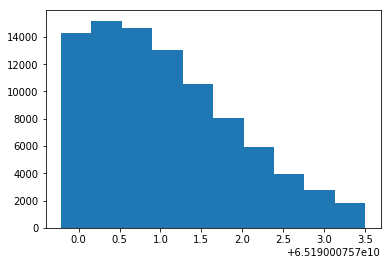

In [95]:
plt.hist(x_trunc)
plt.show()